<a href="https://colab.research.google.com/github/erlanggadewa/Sentiment-Analysis-Review-Steam/blob/roberta/roberta/transform/4e-5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Visit **ChrisMcCormickAI** on YouTube for more explanation.
[Image Reference](https://colab.research.google.com/drive/1Y4o3jh3ZH70tl6mCd76vz_IxX23biCPP#scrollTo=86C9objaKu8f)

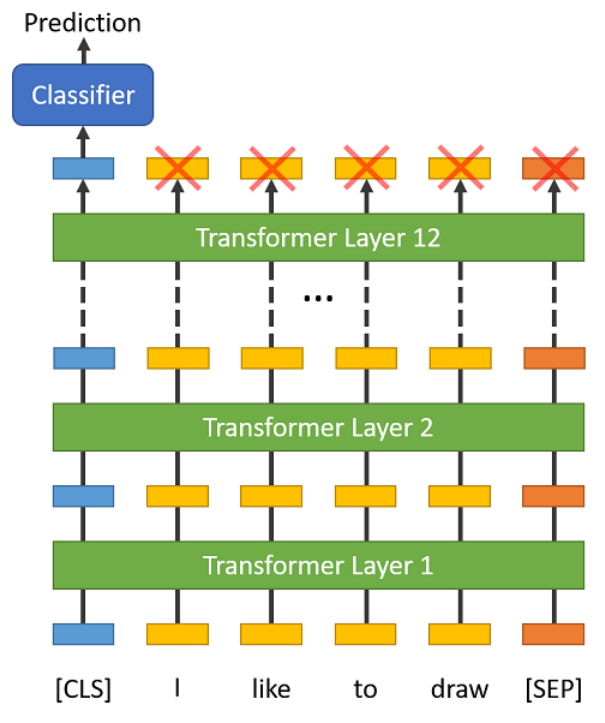

## **1. Cek resource**

In [1]:
import torch

model_name = 'roberta_t'
if torch.cuda.is_available():
  device = torch.device('cuda')

  print('there are %d GPU(s) available.' % torch.cuda.device_count())

  print('we will use the GPU: ', torch.cuda.get_device_name(0))

else:
  print("No GPU available, using the CPU instead")
  device = torch.device("cpu")

there are 1 GPU(s) available.
we will use the GPU:  Tesla T4


In [2]:
!pip install transformers

In [3]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=03575c6a42e7e4bcc05303c878c2b74415c3f5207eb820b22917d446585a8840
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


## **2. Download & load dataset**

In [4]:
import wget
import os

print("Downloading dataset...")

url = 'https://github.com/erlanggadewa/Sentiment-Analysis-Review-Steam/releases/download/production/final-dataset.csv'

if not os.path.exists('./dataset.csv'):
  wget.download(url, './dataset.csv')

In [5]:
import pandas as pd

df = pd.read_csv("./dataset.csv", delimiter=',')
df.shape

(10000, 3)

In [6]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import pandas as pd

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
# Download the punkt_tab resource, which was likely missing
nltk.download('punkt_tab')


# Initialize lemmatizer and stopwords list
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# 0. Convert to String
def convert_to_string(text):
    return str(text)

# 1. Punctuation Removal
def remove_punctuation(text):
    return re.sub(r'[^\w\s]', ' ', text)

# 2. Case Folding
def case_folding(text):
    text = re.sub(r'\s+', ' ', text).strip()
    return text.lower()

# 3. Stopword Removal and Lemmatization
def preprocess_text(text):
    word_tokens = word_tokenize(text)
    # Remove stopwords
    filtered_words = [word for word in word_tokens if word not in stop_words]
    # Lemmatization
    lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_words]
    # Convert list of words back to string
    return ' '.join(lemmatized_words)

# Full preprocessing pipeline
def full_preprocessing(text):
    text = convert_to_string(text)
    text = remove_punctuation(text)
    text = case_folding(text)
    text = preprocess_text(text)  # Process text: remove stopwords and lemmatize
    return text

# Apply preprocessing to your dataframe
df["review"] = df["review"].apply(full_preprocessing)

# Save the final processed text to a CSV file
df.to_csv("clean-dataset.csv", index=False)
df = pd.read_csv("clean-dataset.csv", delimiter=",")
df.sample(5)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


,sentiment,label,review
3186,0,Negative,really imagine ds3 empty though beautifully cr...
9084,1,Positive,word express sure review tell technical thing ...
3104,0,Negative,disappointed game first forced two key cumbers...
4652,0,Negative,game set alternate universe earth real world t...
5702,1,Positive,mmo newcomer enjoy fair bit pretty damn good a...


<ipython-input-7-3638a25a03c5>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette=['#F55','#5A9'])  # Use countplot for direct label counts with custom colors


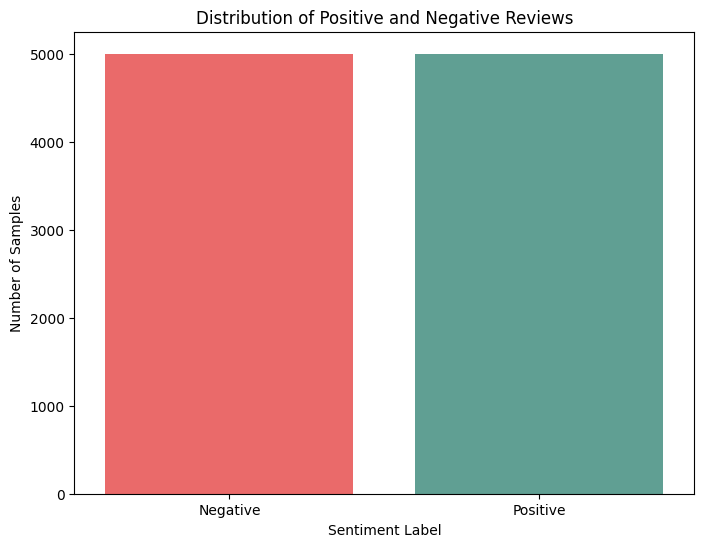

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt


# Plotting the distribution of labels with clearer visualization
plt.figure(figsize=(8, 6))  # Adjust figure size for better readability
sns.countplot(x='label', data=df, palette=['#F55','#5A9'])  # Use countplot for direct label counts with custom colors
plt.title('Distribution of Positive and Negative Reviews')
plt.xlabel('Sentiment Label')
plt.ylabel('Number of Samples')
plt.show()


In [8]:
sentences = df.review.values
labels = df.label.values
sentiments = df.sentiment.values

## **3. Load RoBERTa Tokenizer**

In [9]:
from transformers import RobertaTokenizer

print("Loading RoBERTa Tokenizer")
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

Loading RoBERTa Tokenizer


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [10]:
df.sample(5)

,sentiment,label,review
9055,1,Positive,elder scroll online eso delivers captivating m...
5618,1,Positive,tl dr review 1st playthrough 100 hoursrating 9...
9096,1,Positive,genuinely one best game ever played kept heari...
7525,1,Positive,recommend game certain term like game hold han...
8025,1,Positive,nothing pure art visuals combat gameplay game ...


In [11]:
print("Original: ", sentences[0])

print("Tokenized: ", tokenizer.tokenize(sentences[0]))

print("Token IDS: ", tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))


Original:  fan dsr game fun playable state due garbage port pc wait month good experience buggy mounting jumping certain terrain occasionally lock falling animation causing instant death loss progress unstable crashing frequently progress load world menu open unfinished spell broken stats 0 left value poorly optimized performance randomly chug independent high fidelity environment server issue connection error trying play others 19 march play two monitor game unique issue cursor randomly unlocks game trail onto second monitor causing game minimize click attack often resulting death average enable fullscreen mode issue mouse keyboard even try much potential wasted bc fromsoft bothered support anything rebinding gamepad function scroll spell item bos fight 1000 useless key could bound fun panning cursor around map wasd
Tokenized:  ['fan', 'Ġd', 'sr', 'Ġgame', 'Ġfun', 'Ġplayable', 'Ġstate', 'Ġdue', 'Ġgarbage', 'Ġport', 'Ġpc', 'Ġwait', 'Ġmonth', 'Ġgood', 'Ġexperience', 'Ġbuggy', 'Ġmounting

In [12]:
input_ids = []

for sent in sentences:
  # Check if sent is not nan before encoding
  if isinstance(sent, str) and sent != 'nan':
    encoded_sent = tokenizer.encode(
        sent,
        add_special_tokens = True
    )
    input_ids.append(encoded_sent)

print("Original: ", sentences[0])
print("Token IDs: ", input_ids[0])

Original:  fan dsr game fun playable state due garbage port pc wait month good experience buggy mounting jumping certain terrain occasionally lock falling animation causing instant death loss progress unstable crashing frequently progress load world menu open unfinished spell broken stats 0 left value poorly optimized performance randomly chug independent high fidelity environment server issue connection error trying play others 19 march play two monitor game unique issue cursor randomly unlocks game trail onto second monitor causing game minimize click attack often resulting death average enable fullscreen mode issue mouse keyboard even try much potential wasted bc fromsoft bothered support anything rebinding gamepad function scroll spell item bos fight 1000 useless key could bound fun panning cursor around map wasd
Token IDs:  [0, 19302, 385, 37959, 177, 1531, 39894, 194, 528, 11671, 4103, 46213, 2067, 353, 205, 676, 40399, 12033, 9755, 1402, 15890, 10930, 7014, 3064, 19269, 3735, 10

Max length: 432
Average length: 105.1991
95th percentile: 173.0


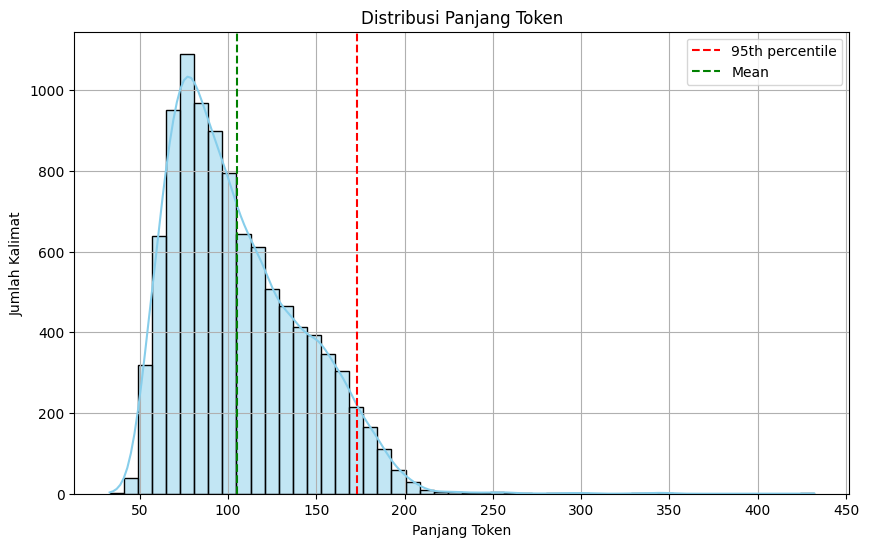

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

# Hitung panjang setiap tokenized input
lengths = [len(ids) for ids in input_ids]

# Statistik dasar
print("Max length:", np.max(lengths))
print("Average length:", np.mean(lengths))
print("95th percentile:", np.percentile(lengths, 95))

# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(lengths, bins=50, kde=True, color='skyblue')
plt.axvline(np.percentile(lengths, 95), color='red', linestyle='--', label='95th percentile')
plt.axvline(np.mean(lengths), color='green', linestyle='--', label='Mean')
plt.title('Distribusi Panjang Token')
plt.xlabel('Panjang Token')
plt.ylabel('Jumlah Kalimat')
plt.legend()
plt.grid(True)
plt.show()


In [14]:
Q1 = np.percentile(lengths, 25)
Q3 = np.percentile(lengths, 75)
IQR = Q3 - Q1

upper_bound = Q3 + 1.5 * IQR

print("Q1:", Q1)
print("Q3:", Q3)
print("IQR:", IQR)
print("Upper Bound:", upper_bound)

avg_input_id_length = math.ceil(upper_bound)


Q1: 77.0
Q3: 129.0
IQR: 52.0
Upper Bound: 207.0


In [15]:
from keras.preprocessing.sequence import pad_sequences

MAX_LEN = 512

print("Padding/truncating all sentences to %d values" % MAX_LEN)
print('Padding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype='long', value=0, truncating='post', padding='post')

print("Done")

Padding/truncating all sentences to 512 values
Padding token: "<pad>", ID: 1
Done


In [16]:
input_ids[80]

array([    0, 19827,   740, 26767,    29,    74,   966,   115,  1532,
       22016,   171,  6554, 20393, 21875,  9796, 10525,  5988,  7428,
       22414, 38988,   177,   138,  8709,  1517, 38988,  1451, 12378,
        8453, 41647,   213,   751,  2190,   443,   478,  1338,  5278,
         298,   582,   856, 21691,  6212,   326,  8939,  3359,   177,
        1032, 11224, 14384,  6148,  1085, 32633,  1085, 14384,  1085,
       14384, 43111,   177, 15328,   177,  8541, 36040, 16611,  5074,
         851,   177,   358, 16490,   778,   115,     2,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [17]:
attention_mask = []

for sent in input_ids:
  att_mask = [int(token_id > 0) for token_id in sent]

  attention_mask.append(att_mask)


## **4. Persiapkan data**

In [18]:
from sklearn.model_selection import train_test_split

# Sinkronisasi awal
num_samples = min(len(input_ids), len(sentiments), len(attention_mask))
input_ids = input_ids[:num_samples]
sentiments = sentiments[:num_samples]
attention_mask = attention_mask[:num_samples]

# Split pertama: train-test
train_input, test_input, train_sentiments, test_sentiments, train_mask, test_mask = train_test_split(
    input_ids,
    sentiments,
    attention_mask,
    stratify=sentiments,
    random_state=2017,
    test_size=0.1
)

# Split kedua: train-validation
train_input, validation_input, train_sentiments, validation_sentiments, train_mask, validation_mask = train_test_split(
    train_input,
    train_sentiments,
    train_mask,
    stratify=train_sentiments,
    random_state=2017,
    test_size=0.15
)


In [19]:
from collections import Counter

print("Train:", Counter(train_sentiments))
print("Validation:", Counter(validation_sentiments))
print("Test:", Counter(test_sentiments))


Train: Counter({np.int64(0): 3825, np.int64(1): 3825})
Validation: Counter({np.int64(0): 675, np.int64(1): 675})
Test: Counter({np.int64(1): 500, np.int64(0): 500})


<ipython-input-20-6b5835b518d1>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette=['#5A9', '#F55'])  # Use countplot for direct label counts with custom colors


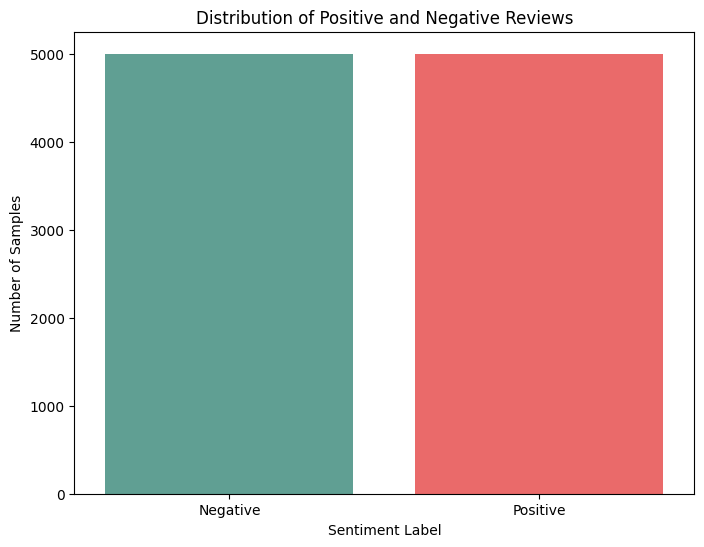

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the distribution of labels with clearer visualization
plt.figure(figsize=(8, 6))  # Adjust figure size for better readability
sns.countplot(x='label', data=df, palette=['#5A9', '#F55'])  # Use countplot for direct label counts with custom colors
plt.title('Distribution of Positive and Negative Reviews')
plt.xlabel('Sentiment Label')
plt.ylabel('Number of Samples')
plt.show()


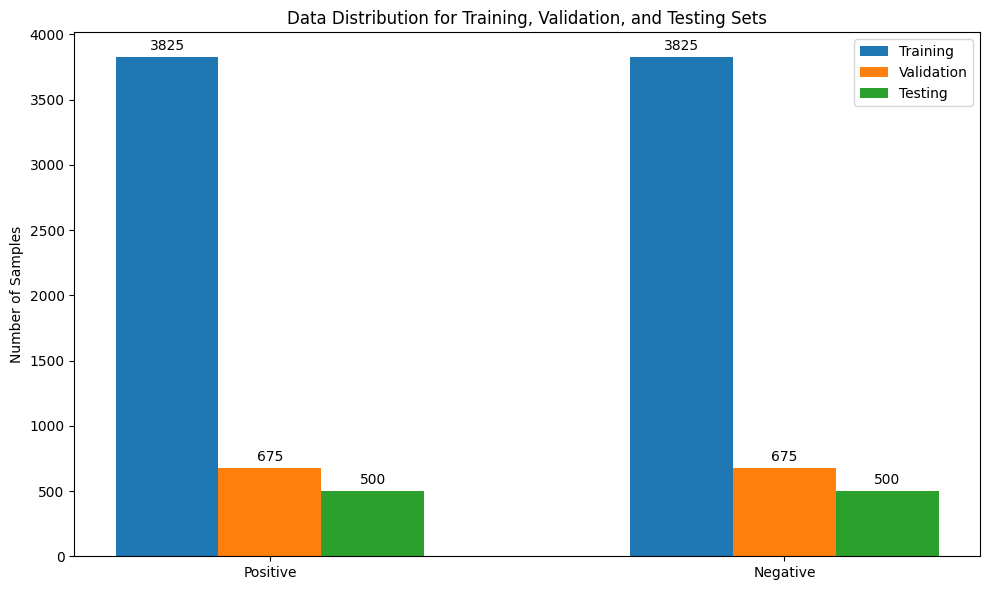

In [21]:

import matplotlib.pyplot as plt
import numpy as np


# Data for the plot (replace with your actual data)
data = {
    'Training': {'Positive': len(train_sentiments[train_sentiments == 1]), 'Negative': len(train_sentiments[train_sentiments == 0])},
    'Validation': {'Positive': len(validation_sentiments[validation_sentiments == 1]), 'Negative': len(validation_sentiments[validation_sentiments == 0])},
    'Testing': {'Positive': len(test_sentiments[test_sentiments == 1]), 'Negative': len(test_sentiments[test_sentiments == 0])}
}

# Create the bar plot
labels = ['Positive', 'Negative']
x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width, data['Training'].values(), width, label='Training')
rects2 = ax.bar(x, data['Validation'].values(), width, label='Validation')
rects3 = ax.bar(x + width, data['Testing'].values(), width, label='Testing')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of Samples')
ax.set_title('Data Distribution for Training, Validation, and Testing Sets')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()
plt.show()

In [22]:

# Calculate the number of samples for each label in each dataset
train_df = pd.DataFrame({'label': train_sentiments})
validation_df = pd.DataFrame({'label': validation_sentiments})
test_df = pd.DataFrame({'label': test_sentiments})

train_counts = train_df['label'].value_counts()
validation_counts = validation_df['label'].value_counts()
test_counts = test_df['label'].value_counts()


# Print the counts for each dataset
print("Training Data:")
print(train_counts)
print("\nValidation Data:")
print(validation_counts)
print("\nTesting Data:")
print(test_counts)

# Create a summary table
summary_data = {'Dataset': ['Training', 'Validation', 'Testing'],
                'Positive': [train_counts.get(1, 0), validation_counts.get(1, 0), test_counts.get(1, 0)],
                'Negative': [train_counts.get(0, 0), validation_counts.get(0, 0), test_counts.get(0, 0)]}
summary_df = pd.DataFrame(summary_data)
print("\nSummary Table:")
summary_df

Training Data:
label
0    3825
1    3825
Name: count, dtype: int64

Validation Data:
label
0    675
1    675
Name: count, dtype: int64

Testing Data:
label
1    500
0    500
Name: count, dtype: int64

Summary Table:


,Dataset,Positive,Negative
0,Training,3825,3825
1,Validation,675,675
2,Testing,500,500


In [23]:
train_input = torch.tensor(train_input)
train_sentiments = torch.tensor(train_sentiments)
train_mask = torch.tensor(train_mask)

validation_input = torch.tensor(validation_input)
validation_sentiments = torch.tensor(validation_sentiments)
validation_mask = torch.tensor(validation_mask)

test_input = torch.tensor(test_input)
test_sentiments = torch.tensor(test_sentiments)
test_mask = torch.tensor(test_mask)

In [24]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32

train_data = TensorDataset(train_input, train_mask, train_sentiments)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_input, validation_mask, validation_sentiments)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

test_data = TensorDataset(test_input, test_mask, test_sentiments)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

## **5. Persiapkan model pre-trained RoBERTa**

In [25]:
from transformers import RobertaForSequenceClassification, RobertaConfig
from torch.optim import AdamW  # Tetap sama

model = RobertaForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False
)


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
params = list(model.named_parameters())

print("The RoBERTa model has {:} different named parameters.".format(len(params)))

print("==== Embedding Layer ====")
for p in params[0:5]:
  print("{:<60} {:>12}".format(p[0], str(tuple(p[1].size()))))

print("==== First Transformers ====")
for p in params[5:21]:
  print("{:<60} {:>12}".format(p[0], str(tuple(p[1].size()))))

print("==== Output Layer ====")
for p in params[-4:]:
  print("{:<60} {:>12}".format(p[0], str(tuple(p[1].size()))))

The RoBERTa model has 201 different named parameters.
==== Embedding Layer ====
roberta.embeddings.word_embeddings.weight                    (50265, 768)
roberta.embeddings.position_embeddings.weight                  (514, 768)
roberta.embeddings.token_type_embeddings.weight                  (1, 768)
roberta.embeddings.LayerNorm.weight                                (768,)
roberta.embeddings.LayerNorm.bias                                  (768,)
==== First Transformers ====
roberta.encoder.layer.0.attention.self.query.weight            (768, 768)
roberta.encoder.layer.0.attention.self.query.bias                  (768,)
roberta.encoder.layer.0.attention.self.key.weight              (768, 768)
roberta.encoder.layer.0.attention.self.key.bias                    (768,)
roberta.encoder.layer.0.attention.self.value.weight            (768, 768)
roberta.encoder.layer.0.attention.self.value.bias                  (768,)
roberta.encoder.layer.0.attention.output.dense.weight          (768, 768)
rob

In [27]:
learning_rate = 4e-5;
optimizer = AdamW(
    model.parameters(),
    lr = learning_rate,
    eps = 1e-8
)

In [28]:
from transformers import get_linear_schedule_with_warmup

epochs = 5

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                             num_warmup_steps = 0,
                                             num_training_steps = total_steps)

In [29]:
import numpy as np

def flat_accuracy(preds, labels):
  pred_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
  return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [30]:
import time
import datetime

def format_time(elapsed):
  elapsed_rounded = int(round(elapsed))
  return str(datetime.timedelta(seconds=elapsed_rounded))

## **6. Training RoBERTa**

In [31]:
import random
import time
import numpy as np
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef, f1_score

# Setup seed
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Simpan history dan log
loss_values = []
validation_accuracies = []
test_accuracies = []
epoch_logs = []

total_training_time = 0
model.to(device)


# Format nama file untuk CSV
lr_str = str(learning_rate)
filename = f"{model_name}_{lr_str}.csv"

for epoch_i in range(0, epochs):
    print("======= Epoch {:} / {:} =======".format(epoch_i + 1, epochs))
    print("Training...")

    t0 = time.time()
    total_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print("Batch {:>5,} of {:>5,}.     Elapsed: {:}".format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()
        outputs = model(b_input_ids,
                        attention_mask=b_input_mask,
                        labels=b_labels)

        loss = outputs[0]
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)
    loss_values.append(avg_train_loss)
    epoch_training_time = time.time() - t0
    total_training_time += epoch_training_time

    print("   Average training loss: {0:.4f}".format(avg_train_loss))
    print("   Training epoch took: {:}".format(format_time(epoch_training_time)))

    # ============================
    #        VALIDATION
    # ============================
    print("\nRunning Validation...")
    t0 = time.time()
    model.eval()

    eval_accuracy = 0
    nb_eval_steps = 0
    all_preds_val = []
    all_labels_val = []

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids,
                            attention_mask=b_input_mask)

        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

        preds = np.argmax(logits, axis=1)
        all_preds_val.extend(preds)
        all_labels_val.extend(label_ids)

    avg_val_accuracy = eval_accuracy / nb_eval_steps
    validation_accuracies.append(avg_val_accuracy)

    report_val = classification_report(all_labels_val, all_preds_val, output_dict=True)
    macro_precision_val = report_val['macro avg']['precision']
    macro_recall_val = report_val['macro avg']['recall']
    macro_f1_val = report_val['macro avg']['f1-score']
    print(classification_report(all_labels_val, all_preds_val))

    mcc_val = matthews_corrcoef(all_labels_val, all_preds_val)
    print("   MCC (Validation): {:.4f}".format(mcc_val))
    print("   F1 Score (Validation - Macro): {:.4f}".format(macro_f1_val))

    # ============================
    #          TESTING
    # ============================
    print("\nRunning Testing...")
    t0 = time.time()
    model.eval()

    test_accuracy = 0
    nb_test_steps = 0
    all_preds_test = []
    all_labels_test = []

    for batch in test_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids,
                            attention_mask=b_input_mask)

        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        tmp_test_accuracy = flat_accuracy(logits, label_ids)
        test_accuracy += tmp_test_accuracy
        nb_test_steps += 1

        preds = np.argmax(logits, axis=1)
        all_preds_test.extend(preds)
        all_labels_test.extend(label_ids)

    avg_test_accuracy = test_accuracy / nb_test_steps
    test_accuracies.append(avg_test_accuracy)

    report_test = classification_report(all_labels_test, all_preds_test, output_dict=True)
    macro_precision_test = report_test['macro avg']['precision']
    macro_recall_test = report_test['macro avg']['recall']
    macro_f1_test = report_test['macro avg']['f1-score']
    print(classification_report(all_labels_test, all_preds_test))

    mcc_test = matthews_corrcoef(all_labels_test, all_preds_test)
    print("   MCC (Testing): {:.4f}".format(mcc_test))
    print("   F1 Score (Testing - Macro): {:.4f}".format(macro_f1_test))

    # ============================
    #     LOG PER EPOCH
    # ============================
    epoch_logs.append({
        "epoch": epoch_i + 1,
        "train_loss": avg_train_loss,
        "val_accuracy": avg_val_accuracy,
        "val_mcc": mcc_val,
        "val_macro_precision": macro_precision_val,
        "val_macro_recall": macro_recall_val,
        "val_macro_f1": macro_f1_val,
        "test_accuracy": avg_test_accuracy,
        "test_mcc": mcc_test,
        "test_macro_precision": macro_precision_test,
        "test_macro_recall": macro_recall_test,
        "test_macro_f1": macro_f1_test,
    })

# Simpan ke CSV
df_logs = pd.DataFrame(epoch_logs)
df_logs.to_csv(filename, index=False)
print(f"Log training per epoch disimpan di '{filename}'")

print("Training complete!")
print("Total training time: {:}".format(format_time(total_training_time)))


======= Epoch 1 / 5 =======
Training...
Batch    40 of   240.     Elapsed: 0:01:46
Batch    80 of   240.     Elapsed: 0:03:39
Batch   120 of   240.     Elapsed: 0:05:33
Batch   160 of   240.     Elapsed: 0:07:28
Batch   200 of   240.     Elapsed: 0:09:23
   Average training loss: 0.5606
   Training epoch took: 0:11:18

Running Validation...
              precision    recall  f1-score   support

           0       0.92      0.71      0.80       675
           1       0.76      0.94      0.84       675

    accuracy                           0.82      1350
   macro avg       0.84      0.82      0.82      1350
weighted avg       0.84      0.82      0.82      1350

   MCC (Validation): 0.6667
   F1 Score (Validation - Macro): 0.8221

Running Testing...
              precision    recall  f1-score   support

           0       0.91      0.72      0.81       500
           1       0.77      0.93      0.84       500

    accuracy                           0.83      1000
   macro avg       0.84

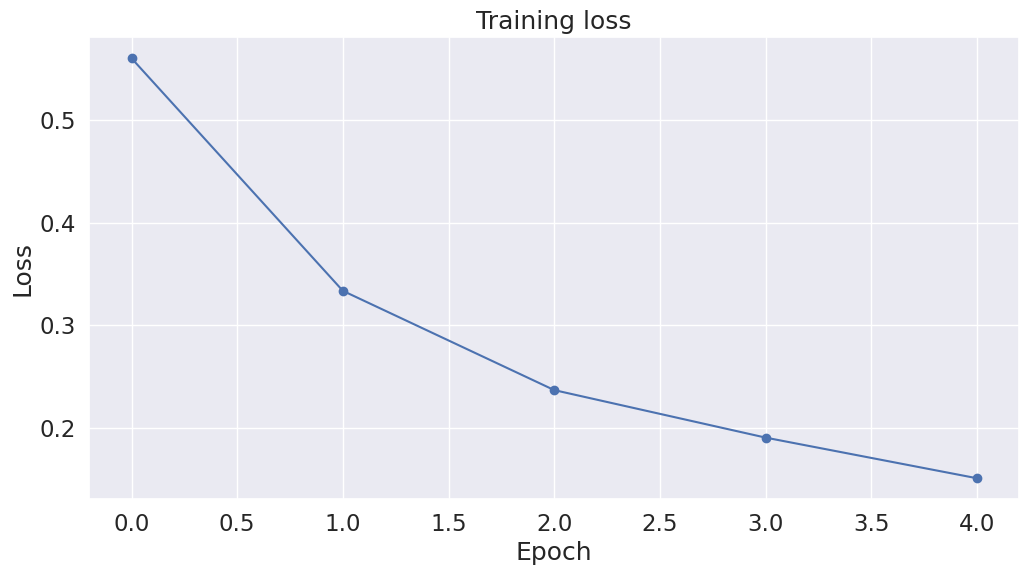

In [32]:
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')

import seaborn as sns

sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(loss_values, 'b-o')

plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [33]:
# download the output file csv
from google.colab import files
files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **7. Predict dan Evaluate**

In [34]:
print("Predicting labels for {:,} test sentences".format(len(test_input)))

model.eval()

prediction, true_labels = [], []

for batch in test_dataloader:
  batch = tuple(t.to(device) for t in batch)

  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
    outputs = model(b_input_ids,

                    attention_mask=b_input_mask)

  logits = outputs[0]

  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  prediction.append(logits)
  true_labels.append(label_ids)

print(" DONE.")

Predicting labels for 1,000 test sentences
 DONE.


In [35]:
from sklearn.metrics import matthews_corrcoef

flat_prediction = [item for sublist in prediction for item in sublist]
flat_prediction = np.argmax(flat_prediction, axis=1).flatten()

flat_true_labels = [item for sublist in true_labels for item in sublist]

mcc = matthews_corrcoef(flat_true_labels, flat_prediction)

print("MCC: %.3f" %mcc)

MCC: 0.796


In [36]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(flat_true_labels, flat_prediction)

print("ACC: %.3f" %acc)


ACC: 0.898



Hyperparameters:
- Learning Rate: 4e-05
- Batch Size: 32
- Epochs: 5
MCC: 0.80
ACC: 0.90
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       500
           1       0.90      0.89      0.90       500

    accuracy                           0.90      1000
   macro avg       0.90      0.90      0.90      1000
weighted avg       0.90      0.90      0.90      1000



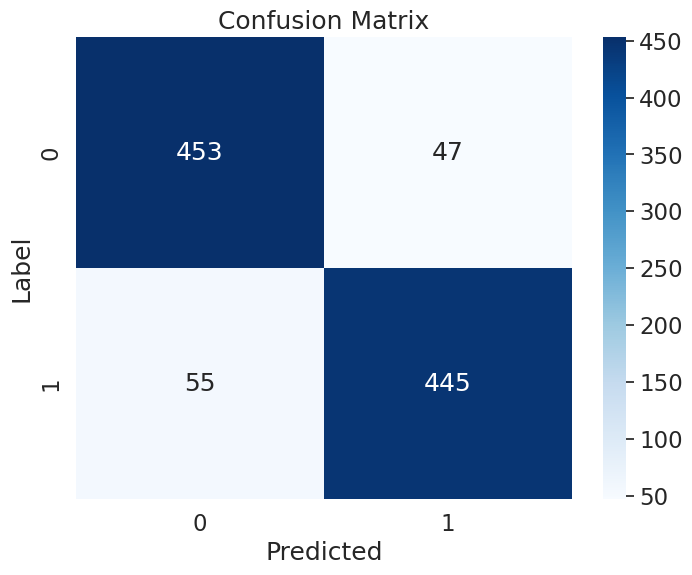

In [37]:

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


# Additional information you might want to display:
# * Training time per epoch
# * Hyperparameters used (learning rate, batch size, epochs, etc.)
# * Number of training examples
# * Number of validation examples
# * Number of test examples
# * Model architecture details
# * Other relevant metrics, e.g., precision, recall, F1-score (if applicable)

# Example of displaying hyperparameters
print("\nHyperparameters:")
print(f"- Learning Rate: {learning_rate}")  # Replace with your actual learning rate
print(f"- Batch Size: {batch_size}") # Replace with your actual batch size
print(f"- Epochs: {epochs}") # Replace with your actual epoch number

mcc = matthews_corrcoef(flat_true_labels, flat_prediction)
print("MCC: %.2f" % mcc)

acc = accuracy_score(flat_true_labels, flat_prediction)
print("ACC: %.2f" % acc)

# Generate classification report
print(classification_report(flat_true_labels, flat_prediction))

# Generate and plot confusion matrix
cm = confusion_matrix(flat_true_labels, flat_prediction)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Label")
plt.title("Confusion Matrix")
plt.show()